In [1]:
import arviz as az

In [2]:
from util import stan_cache

In [3]:
update_mpl_setting()

In [4]:
np.random.seed(1234)

In [5]:
N1, N2, N3 = 5000, 6000, 7000
p1, p2, p3 = 0.04, 0.042, 0.06

In [6]:
n1 = np.random.binomial(n=N1, p=p1)
n2 = np.random.binomial(n=N2, p=p2)
n3 = np.random.binomial(n=N3, p=p3)

In [7]:
model = """
data { 
  int<lower=1> g;
  int<lower=0> n[g];
  int<lower=0> N[g];
}
parameters {
  real<lower=0, upper=1> p[g];
}
model {
  for (i in 1:g) {
    n[i] ~ binomial(N[i], p[i]);
  }
}
generated quantities {
  real<lower=0> odds[g];
  real<lower=0, upper=1> c2[g, g];
  real risk_ratio[g, g];
  real risk_diff[g, g];

  for (i in 1:g) {  
    c2[i, i] = 0;
    odds[i] = p[i] / (1 - p[i]);
    risk_ratio[i, i] = 0;
    risk_diff[i, i] = 0;
  }

  for (i in 1:(g-1)) {
    for (j in (i+1):g) {
      c2[i, j] = p[i] - p[j] > 0 ? 1 : 0;
      c2[j, i] = !(c2[i, j]);  

      risk_ratio[i, j] = p[i] / p[j];
      risk_ratio[j, i] = p[j] / p[i];  

      risk_diff[i, j] = p[i] - p[j];
      risk_diff[j, i] = - risk_diff[i, j];  
    }  
  }
}
"""

In [8]:
data = {
    "g": 3,
    "N": [N1, N2, N3],
    "n": [n1, n2, n3]
}

sm = stan_cache(model_code=model)
params = sm.sampling(data=data, iter=6000, warmup=1000)

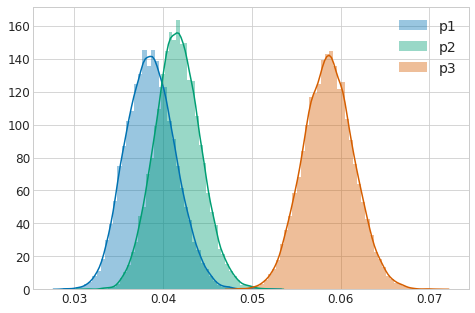

In [9]:
sns.distplot(params["p"][:, 0], label="p1")
sns.distplot(params["p"][:, 1], label="p2")
sns.distplot(params["p"][:, 2], label="p3")
plt.legend()

In [10]:
def describe_params(target):
    ret = pd.concat([
        pd.Series(params[target][:, 0]).to_frame().describe().rename(columns={0: f"{target}1"}).T,
        pd.Series(params[target][:, 1]).to_frame().describe().rename(columns={0: f"{target}2"}).T,
        pd.Series(params[target][:, 2]).to_frame().describe().rename(columns={0: f"{target}3"}).T,
    ])
    
    return ret

In [11]:
def show(target):
    ret = []
    for i in range(3):
        for j in range(3):
            ret.append(np.mean(params[target][:, i, j]))
    df = pd.DataFrame(np.array(ret).reshape(3, 3))
    names = [f"group{i}" for i in range(1, 4)]
    df.columns = names
    df.index = names
    return df

In [12]:
describe_params("p")

,count,mean,std,min,25%,50%,75%,max
p1,20000.0,0.038606,0.002745,0.028754,0.036681,0.038544,0.040434,0.052196
p2,20000.0,0.041634,0.002557,0.031266,0.039910,0.041600,0.043325,0.052513
p3,20000.0,0.058629,0.002827,0.048168,0.056688,0.058609,0.060502,0.071022


In [13]:
describe_params("odds")

,count,mean,std,min,25%,50%,75%,max
odds1,20000.0,0.040165,0.002972,0.029605,0.038077,0.040090,0.042138,0.055070
odds2,20000.0,0.043451,0.002785,0.032275,0.041569,0.043406,0.045287,0.055424
odds3,20000.0,0.062290,0.003191,0.050605,0.060095,0.062258,0.064398,0.076452


In [14]:
show("c2")

,group1,group2,group3
group1,0.0000,0.2069,0.0
group2,0.7931,0.0000,0.0
group3,1.0000,1.0000,0.0


In [15]:
show("risk_ratio")

,group1,group2,group3
group1,0.000000,0.930761,0.660023
group2,1.083885,0.000000,0.711766
group3,1.526359,1.413477,0.000000


In [16]:
show("risk_diff")

,group1,group2,group3
group1,0.000000,-0.003028,-0.020023
group2,0.003028,0.000000,-0.016995
group3,0.020023,0.016995,0.000000
